## Global PTM analysis of human proteome
#### Last updated 2022-08-05

The notebook here contains a global analysis of post-translational modifications across the human proteome with respect to solvent accessibility. 

## Data used
This notebook uses several different sources for data annotations

#### A comment on the predicted intrinsically disordered regions
The disordered regions identified here were predicted using [metapredict V2](https://www.biorxiv.org/content/10.1101/2022.06.06.494887v1), a recent update to our [metapredict](http://dx.doi.org/10.1016/j.bpj.2021.08.039) disorder predictor. For insight into how this works and the potential caveats, please see the associated papers or the [metapredict documentation](https://metapredict.readthedocs.io/).

#### A comment on the AlphaFold2 derived data
The AlphaFold2 binding accessibility scores were calculated by taking each predicted structure from AlphaFold2 and computing the solvent-accessibility of each residue using a 0.7 nm probe radius. When computing *bona fide* solvent accessibility, the convention is to use a 0.14 nm probe radius. By increasing the probe radius 5x we are now asking about residues that could accommodate interaction via a sphere meant to represent that of an alpha helix, binding motif, or folded interface. This score is used in the context of folded domains but is ignored for IDRs where we assume full accessibility.

Structural data was downloaded from the [AlphaFold2 EBI portal](https://alphafold.ebi.ac.uk/download), and solvent accessibility was calculated using our simulation and structural analysis tool [SOURSOP](https://soursop.readthedocs.io/), which itself is built on [MDTraj](https://mdtraj.org/).

Naturally, it goes without saying that (1) [structural predictions by AlphaFold2 are predictions](https://twitter.com/gonenlab/status/1555221688987447296?s=20&t=V21X9deI3thClAwy2KDgrg) and that (2) [folded domains also exist in dynamic and structurally heterogeneous ensembles](https://twitter.com/Mizimmer90/status/1555553300174495752?s=20&t=V21X9deI3thClAwy2KDgrg) that will re-organize themselves through subtle fluctuations and large-scale conformational re-arrangements. The application of this accessibility score is a convenient coarse-graining of the structural landscape to make asking proteome-wide statistical questions tractable.

#### A comment on the post-translational modification (PTM) data
PTM data were downloaded from [proteome scout](https://proteomescout.wustl.edu/compendia), an online database that combines a wide array of different PTM databases generating a convenient single source for PTM data. 

### Publication references
Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2021). Metapredict: a fast, accurate, and easy-to-use predictor of consensus disorder and structure. Biophysical Journal, 120(20), 4312–4319.

Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2022). Metapredict V2: An update to metapredict, a fast, accurate, and easy-to-use predictor of consensus disorder and structure. In bioRxiv (p. 2022.06.06.494887). https://doi.org/10.1101/2022.06.06.494887

Jumper, J., Evans, R., Pritzel, A., Green, T., Figurnov, M., Ronneberger, O., Tunyasuvunakool, K., Bates, R., Žídek, A., Potapenko, A., Bridgland, A., Meyer, C., Kohl, S. A. A., Ballard, A. J., Cowie, A., Romera-Paredes, B., Nikolov, S., Jain, R., Adler, J., … Hassabis, D. (2021). Highly accurate protein structure prediction with AlphaFold. Nature, 596(7873), 583–589.

Tunyasuvunakool, K., Adler, J., Wu, Z., Green, T., Zielinski, M., Žídek, A., Bridgland, A., Cowie, A., Meyer, C., Laydon, A., Velankar, S., Kleywegt, G. J., Bateman, A., Evans, R., Pritzel, A., Figurnov, M., Ronneberger, O., Bates, R., Kohl, S. A. A., … Hassabis, D. (2021). Highly accurate protein structure prediction for the human proteome. Nature, 596(7873), 590–596.

McGibbon, R. T., Beauchamp, K. A., Harrigan, M. P., Klein, C., Swails, J. M., Hernández, C. X., Schwantes, C. R., Wang, L.-P., Lane, T. J., & Pande, V. S. (2015). MDTraj: a modern, open library for the analysis of molecular dynamics trajectories. Biophysical Journal, 109(8), 1528–1532.

Holehouse, A. S., & Naegle, K. M. (2015). Reproducible Analysis of Post-Translational Modifications in Proteomes--Application to Human Mutations. PloS One, 10(12), e0144692.

Matlock, M. K., Holehouse, A. S., & Naegle, K. M. (2015). ProteomeScout: a repository and analysis resource for post-translational modifications and proteins. Nucleic Acids Research, 43(Database issue), D521–D530.

In [2]:
###
### PLOTTING SETTINGS ####
###

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

## conversion dictionaries 
AA_letter_to_code = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly', 'H': 'His','I': 'Ile',
                     'L': 'Leu','K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}

## custom color palettes
AA_type_palette={'A':'#000000','I':'#000000','L':'#000000','M':'#000000','V':'#000000',
                 'F':'#f2a139','Y':'#f2a139','W':'#f2a139',
                 'D':'#eb3628','E':'#eb3628',
                 'R':'#201beb','K':'#201beb',
                 'P':'#bf42b2','C':'#fbe74f',
                 'N':'#306e22','Q':'#306e22','G':'#306e22','S':'#306e22','T':'#306e22','H':'#306e22'}

location_palette = {'SA_fd_sites':'#c7c6b5', 'idr_sites':'#61aced', 'fd_sites':'#c7c6b5'}

auto_ptm_palette = {'Phosphoserine': '#e0d82f', 'Phosphothreonine': '#e0d82f', 'Phosphotyrosine': '#e0d82f',
                    'Ubiquitination': '#d487d6', 'N6-acetyllysine': '#2294f2',  'N-Glycosylation': '#6b2424',
                    'Methylation': '#154d20', 'Sumoylation': '#8d5fa3', 'Dimethylation': '#154d20',
                    'O-Glycosylation': '#6b2424', 'Omega-N-methylarginine': '#154d20', 'N6-succinyllysine': '#2e2e2e',
                    'N-acetylalanine': '#2294f2', 'N-acetylmethionine': '#2294f2','S-nitrosocysteine': '#2e2e2e',
                    'N6,N6-dimethyllysine': '#154d20', 'Asymmetric dimethylarginine': '#154d20','Y': '#a1a1a1',
                    'A': '#a1a1a1','N': '#a1a1a1','R': '#a1a1a1','K': '#a1a1a1','R_K_H': '#a1a1a1','M': '#a1a1a1',
                    'T_S': '#a1a1a1','C': '#a1a1a1','T': '#a1a1a1','S': '#a1a1a1'}


# list of PTMs we're going to explore in this analysis
ptms_of_interest = ['Phosphoserine', 'Phosphothreonine', 'Phosphotyrosine', 'Ubiquitination', 'N6-acetyllysine', 'N-Glycosylation', 
 'Methylation', 'Sumoylation', 'Dimethylation', 'O-Glycosylation', 'Omega-N-methylarginine',  'N6-succinyllysine',
 'N-acetylalanine', 'N-acetylmethionine', 'S-nitrosocysteine', 'N6,N6-dimethyllysine', 'Asymmetric dimethylarginine']


In [3]:
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks, si_proteins, si_sites
from shephard.tools import domain_tools, sequence_tools

### Read in Data
The first thing we do is read in data.

Here we read in the human proteome as a SHEPHARD proteins file, and then add AlphaFold2-derived binding accessibility scores, intrinsically disordered regions, and finally, PTMs.


In [4]:
print('Reading in human proteome...')
af2_prot = shephard.proteome.Proteome([])
si_proteins.add_proteins_from_file(af2_prot,'../shprd_data/shprd_proteins_filtered_human_af2_f1acc.tsv')

print('Reading in all AlphaFold2 binding accessible tracks...')
si_tracks.add_tracks_from_file(af2_prot, '../shprd_data/shprd_tracks_filtered_af2_f1_solv_acc.tsv', mode='values')

print('Reading in all IDRs...')

# si_domains.add_domains_from_file(af2_prot, '../shprd_data/shprd_domains_human_IDRs_0.420.tsv') # metapredict1 IDRS
si_domains.add_domains_from_file(af2_prot, '../shprd_data/shprd_domains_idrs_metapredict_v2.tsv' ) # metapredict2 IDRS

print('Reading in all PTMs...')
si_sites.add_sites_from_file(af2_prot, '../shprd_data/shprd_sites_filtered_proteomescout.tsv')

Reading in human proteome...
Reading in all AlphaFold2 binding accessible tracks...
Reading in all IDRs...
Reading in all PTMs...


#### Construct mapping of PTM types to residues
The code below cycles through each individual PTM in the human proteome and maps what type of residue that PTM modifies. It also generates a count of how many of each type PTM there are. Finally, once this is done for all PTMs, we rebuild dictionaries for the ptms of interest (as defined above in the `ptms_of_interest` list), as well as create a non-redudant list of which residues are modified by one or more of those PTMs.

In [4]:
type_to_residue = {}
type_to_count = {}

# for every site in the human proteome
for site in af2_prot.sites:
    
    # if we've never seen this type of site (PTM) before
    # initialize some things
    if site.site_type not in type_to_residue:
        type_to_residue[site.site_type] = set([])
        type_to_count[site.site_type] = 0
        
    # otherwise, add the site residue to the set of residues associated
    # with this PTM type
    type_to_residue[site.site_type].add(site.residue)
    
    # for posterity, we also keep track of how many of each site type
    # are here!
    type_to_count[site.site_type] = type_to_count[site.site_type] + 1
        
        
# focusing on the PTMs we're going to explore in this analysis using
# the ptms_of_interest list, we cycle through each of the ptms_of_interest..
PTM_target_dict = {}
unique_residues = []
for ptm in ptms_of_interest:
    PTM_target_dict[ptm] = list(type_to_residue[ptm])
    
    # for all residues found, extend an ever-growing (redundant)
    # list called unique residues
    unique_residues.extend(list(type_to_residue[ptm]))
    
# finally make the unique_residues list non-redudant by casting
# to a set and then back to a list
unique_residues = list(set(unique_residues))    
    

### Annotate PTM sites as being solvent-accessible
We first annotate PTM sites as those which are solvent accessible or not

In [5]:
# annotate any solvent accessible PTMs  
# here solvent accessable is defined as af2_SAS > 10 

# for each site (PTM) in human proteome...
for s in af2_prot.sites:
    
    
    # check if site is solvent accesable using our AlphaFold2 solvent
    # accessibility - note we do this for ALL residues, including those
    # in IDRs, although we don't typically
    if s.get_track_value('af2_f1_solv_acc') > 0:
        s.add_attribute('af2_SA', True)    

### Annotate PTM sites as being in IDRs
We next annotate PTM sites that are found as in IDRs as being `in_IDR`

In [6]:
# annotate any sites in IDRs
for d in af2_prot.domains:
    if d.domain_type == 'IDR':
        for s in d.sites:
            s.add_attribute('in_IDR', True)

In [7]:
# iterate over each PTM of interest in the PTM_target_dict
for ptm_type in PTM_target_dict:
    
    # generate a list of all sites in the proteome that match
    # the current ptm_type
    sites_of_interest = []    
    for s in af2_prot.sites:
        if s.site_type == ptm_type:
            sites_of_interest.append(s)
    
    # reset some counters
    idr_ptms = 0
    fd_ptms = 0
    SA_fd_ptms = 0

    # finally for each site of interest ask
    for s in sites_of_interest:
        
        # if its in an IDR, increment the idr_ptms counter
        if 'in_IDR' in s.attributes:
            idr_ptms = idr_ptms + 1

        # otherwise its in a folded domain so increment the folded
        # domains counter
        else:
            fd_ptms = fd_ptms + 1

            # and finally if in a folded domain and folded accessible increment
            # solvent accessible in folded domain counter
            if 'af2_SA' in s.attributes:
                SA_fd_ptms = SA_fd_ptms + 1

    # finally, we add all this info to the proteome as an attribute linked to a dictionary providing
    # statistics for each type of PTM
    af2_prot.add_attribute(f"ana_{ptm_type}_data", {'sites_of_interest':len(sites_of_interest), 
                                                  'idr_sites':idr_ptms,
                                                  'fd_sites':fd_ptms,
                                                  'SA_fd_sites':SA_fd_ptms,
                                                  'target_data': "_".join(PTM_target_dict[ptm_type])}, safe=False)



### Analysis for PTM target residues
This next section now investigates all residues that COULD be modified by a given PTM. 

To do this we make use of the `build_mega_string()` function, a function found in the `sequence_tools` module that lets you build a single long amino acid string from all the protein sequences in a proteome.

In [8]:
# build and annotate megastring of proteome 
# the sequence_tools.build_mega_string() function is a function that 
# takes in a proteome or a list of objects that have a .sequence variable
# (e.g. list of proteins or list of domains) and returns a single long
# string with all sequences concatanated
af2_prot.add_attribute('mega_string_prot', sequence_tools.build_mega_string(af2_prot))

# build and annotate megastring of IDR domains 
af2_prot.add_attribute('mega_string_IDR', sequence_tools.build_mega_string(af2_prot.domains))

#### Calculate statistics on PTM-modifiable residues
Basically, we're going to compute various statistics for ALL residues of each type that can be modified. Note this includes those that are actually modified.

In [9]:
# first initialize an empty sites stat dictionary 
# of annotated PTM target residues. 
# 
site_stat_dict = {}
for t in unique_residues:
    
    site_stat_dict[t] = {'sites_of_interest':0, 
                         'idr_sites':0, 
                         'fd_sites':0, 
                         'SA_fd_sites':0} 
    

# iterate across every unique residue type that gets modified
for s in unique_residues:
    
    print(f"Getting counts for {s}...")
    
    # get total count of the residue in the human proteome
    site_stat_dict[s]['sites_of_interest'] = af2_prot.attribute('mega_string_prot').count(s)
    
    # get total count of residue in all IDRs
    site_stat_dict[s]['idr_sites'] = af2_prot.attribute('mega_string_IDR').count(s)
    
    # get total count of residue sites in folded domains  
    site_stat_dict[s]['fd_sites'] = site_stat_dict[s]['sites_of_interest'] - site_stat_dict[s]['idr_sites']
    
    


Getting counts for S...
Getting counts for T...
Getting counts for C...
Getting counts for Y...
Getting counts for A...
Getting counts for N...
Getting counts for M...
Getting counts for H...
Getting counts for R...
Getting counts for K...


#### Compute solvent-accessible 

In [10]:
# iterate and count all solvent accessable sites in All Folded domains in the human proteome
protein_count = 0

# for each protein in proteome
for p in af2_prot:
    
    # extract the AlphaFold2 solvent-accessible track
    local_track = p.get_track_values('af2_f1_solv_acc')
    
    # for each type of residue 
    for s in unique_residues: 
        
        # iterate through the protein index positions of all residues
        # of type s in the protein sequence
        for residue_position in sequence_tools.find_string_positions(s, p.sequence):
            
            # check if target is in solvent accessable
            if p.track('af2_f1_solv_acc').values_region(residue_position) > 10:
                
                # if this position does not overlap with an IDR then we've found another
                # solvent accessible surface residue in a folded domain
                if len(p.get_domains_by_position_and_type(residue_position, 'IDR')) == 0:
                    site_stat_dict[s]['SA_fd_sites'] = site_stat_dict[s]['SA_fd_sites'] + 1 
    
    # return progress
    protein_count = protein_count + 1
    if protein_count % 2500 == 0:
        print(f"On protein {protein_count} of {len(af2_prot)} ...")

On protein 2500 of 20061 ...
On protein 5000 of 20061 ...
On protein 7500 of 20061 ...
On protein 10000 of 20061 ...
On protein 12500 of 20061 ...
On protein 15000 of 20061 ...
On protein 17500 of 20061 ...
On protein 20000 of 20061 ...


In [11]:
# add stats for sets of targets as proteome attributes 

# this list will be a list of strings that define the target (residues) that
# are modified by a specific type of PTM. We build this list here and will
# use it later
target_name_list = []

# for each different type of PTM (recall that PTM_target_dict is a dictionary that
# maps a PTM name to a list of one-or-more residues that are modified by that
# PTM;
for ptm_type in PTM_target_dict:
    
    # create a unique string based on this target residues
    target_name = "_".join(PTM_target_dict[ptm_type])
    
    # check to see if this set of residues has been annotated 
    # yet
    if f"ana_{target_name}_data" not in af2_prot.attributes:
        
        # update the target_name_list
        target_name_list.append(target_name)
        
        # the loop below asks, for the set of residues associated with, the current
        # ptm of interest how many examples of that residue are there found:
        #
        #  1. across the whole proteome (sites_of_interest)
        #  2. within idrs only (idr_sites)
        #  3. in folded domains only (fd_sites)
        #  4. in folded domains and solvent accessible (SA_fd_sites)
        
        sites_of_interest = 0
        idr_sites = 0
        fd_sites = 0
        SA_fd_sites = 0
        
        for t in PTM_target_dict[ptm_type]:
            
            sites_of_interest = sites_of_interest + site_stat_dict[t]['sites_of_interest']
            
            idr_sites = idr_sites + site_stat_dict[t]['idr_sites']
            
            fd_sites = fd_sites + site_stat_dict[t]['fd_sites']
            
            SA_fd_sites = SA_fd_sites + site_stat_dict[t]['SA_fd_sites'] 
        
        # add to proteome as a dictionary which can be referenced based on the
        # the target_name string
        af2_prot.add_attribute(f"ana_{target_name}_data", {'sites_of_interest':sites_of_interest, 
                                                          'idr_sites':idr_sites,
                                                          'fd_sites':fd_sites,
                                                          'SA_fd_sites':SA_fd_sites,
                                                          'target_data': target_name})



### Summary of calculated data
Having gone through all this, it's useful to take stock and summarize the analyses we've done upto this point

In [12]:
print("MODIFICATION                                          : count (fraction of all)")
print("--------------------------------------------------------------------------------")
for ptm_type in PTM_target_dict:
    
    # name 
    n = f'ana_{ptm_type}_data'
    
    # we're just extracting the raw numbers here  to make the 
    # string formatting easier to read below; the variables here are
    # temporary
    res_mod = af2_prot.attribute(n)['target_data']
    tot = af2_prot.attribute(n)['sites_of_interest']
    in_idrs = af2_prot.attribute(n)['idr_sites']
    in_fds = af2_prot.attribute(n)['fd_sites']
    in_sa_fds = af2_prot.attribute(n)['SA_fd_sites']
    
    
    
    print(f'For {ptm_type} we have:')
    print(f"  Residues modified                                   : {res_mod.replace('_',', ')} ")
    print(f"  Total number of modifications                       : {tot} ")
    print(f"  Number of modifications in IDRs                     : {in_idrs} ({np.round(in_idrs/tot,3)})")
    print(f"  Number of modifications in FDs (all)                : {in_fds} ({np.round(in_fds/tot,3)})")
    print(f"  Number of modifications in FDs (binding-accessible) : {in_sa_fds} ({np.round(in_sa_fds/tot,3)})")
    print('')
    
    

MODIFICATION                                          : count (fraction of all)
--------------------------------------------------------------------------------
For Phosphoserine we have:
  Residues modified                                   : S 
  Total number of modifications                       : 131681 
  Number of modifications in IDRs                     : 90160 (0.685)
  Number of modifications in FDs (all)                : 41521 (0.315)
  Number of modifications in FDs (binding-accessible) : 24335 (0.185)

For Phosphothreonine we have:
  Residues modified                                   : T 
  Total number of modifications                       : 54168 
  Number of modifications in IDRs                     : 27500 (0.508)
  Number of modifications in FDs (all)                : 26668 (0.492)
  Number of modifications in FDs (binding-accessible) : 15846 (0.293)

For Phosphotyrosine we have:
  Residues modified                                   : Y 
  Total number of modificat

### PLOTTING 

#### Build dataframes of PTMs and Target data
The cell below constructs a series of lists which we then use to populate dataframes for plotting


In [13]:

# initialize lists
sites = []
sites_of_interest = []
idr_ptms = []
fd_ptms = []
SA_fd_ptms = []
grouping = []

# initialize lists
p_sites = []
p_sites_of_interest = []
p_idr_ptms = []
p_fd_ptms = []
p_SA_fd_ptms = []

# this is a list where each element is either the names of PTM types ('Phosphoserine','Phosphothreonine' etc)
# or the sets of residues that one (or more) PTM type will modify
ptms_and_targets = list(PTM_target_dict.keys()) + list(set(target_name_list))


# we now cycle over all PTM types and all residue groups that are modified 
# by those PTMs. Basically here sites are either positions in the proteome
# that are modified OR residues of a type that could be modified by a PTM
for site_type in ptms_and_targets:
    
    # ana_data is a string which corresponds to an attribute in the proteome (added above)
    ana_data = f"ana_{site_type}_data"
    
    # site name 
    sites.append(site_type)
    
    # total count
    sites_of_interest.append(af2_prot.attribute(ana_data)['sites_of_interest'])
    
    # count of the site in idrs
    idr_ptms.append(af2_prot.attribute(ana_data)['idr_sites'])
    
    # count of the site in folded domains
    fd_ptms.append(af2_prot.attribute(ana_data)['fd_sites'])
    
    # count of the site in folded domains that are also accessible
    SA_fd_ptms.append(af2_prot.attribute(ana_data)['SA_fd_sites'])
    
    # the set of residues modified by the associated PTM or that are
    # the current site_type, if we're looking at residues
    group_s = af2_prot.attribute(ana_data)['target_data']
    grouping.append(group_s)
    
    # if we're looking at one of the various PTM types (i.e. not)
    # the sets of 1 or more residues, in which case site_type WOULD
    # equal group_s...
    
    
    if group_s != site_type: 
        
        # get the name of the attribute associated with those residues
        target_data = "ana_%s_data" % group_s
        
        # add this to the percent
        p_sites.append(site_type)
        
        # fraction of all residues that COULD be modified 
        p_sites_of_interest.append(af2_prot.attribute(ana_data)['sites_of_interest']/af2_prot.attribute(target_data)['sites_of_interest'])
        
        # fraction of all residues in IDRs that COULD be modified 
        p_idr_ptms.append(af2_prot.attribute(ana_data)['idr_sites']/af2_prot.attribute(target_data)['idr_sites'])
        
        # fraction of all residues in folded domains that COULD be modified 
        p_fd_ptms.append(af2_prot.attribute(ana_data)['fd_sites']/af2_prot.attribute(target_data)['fd_sites'])
        
        # fraction of all solvent accessible residues in folded domains that could be modified
        p_SA_fd_ptms.append(af2_prot.attribute(ana_data)['SA_fd_sites']/af2_prot.attribute(target_data)['SA_fd_sites'])

        
        
    
    
    

In [14]:
# build data frames using the lists defined above
out_data = pd.DataFrame({'sites':sites, 'sites_of_interest':sites_of_interest,'idr_sites':idr_ptms,'grouping':grouping,
                         'fd_sites':fd_ptms,'SA_fd_sites':SA_fd_ptms})

p_out_data = pd.DataFrame({'sites':p_sites, 'sites_of_interest':p_sites_of_interest,'idr_sites':p_idr_ptms,
                         'fd_sites':p_fd_ptms,'SA_fd_sites':p_SA_fd_ptms})

In [15]:
# transform data for easy plotting
data_transformed = pd.melt(out_data.reset_index(), id_vars=["sites", 'grouping'], value_vars=['sites','sites_of_interest','idr_sites',
       'fd_sites','SA_fd_sites'])

p_data_transformed = pd.melt(p_out_data.reset_index(), id_vars=["sites"], value_vars=['sites','sites_of_interest','idr_sites', 'fd_sites','SA_fd_sites'])
p_data_transformed['value']= p_data_transformed['value']*100



#### Plot data on specific PTM

meta NOT subset; don't know how to subset; dropped


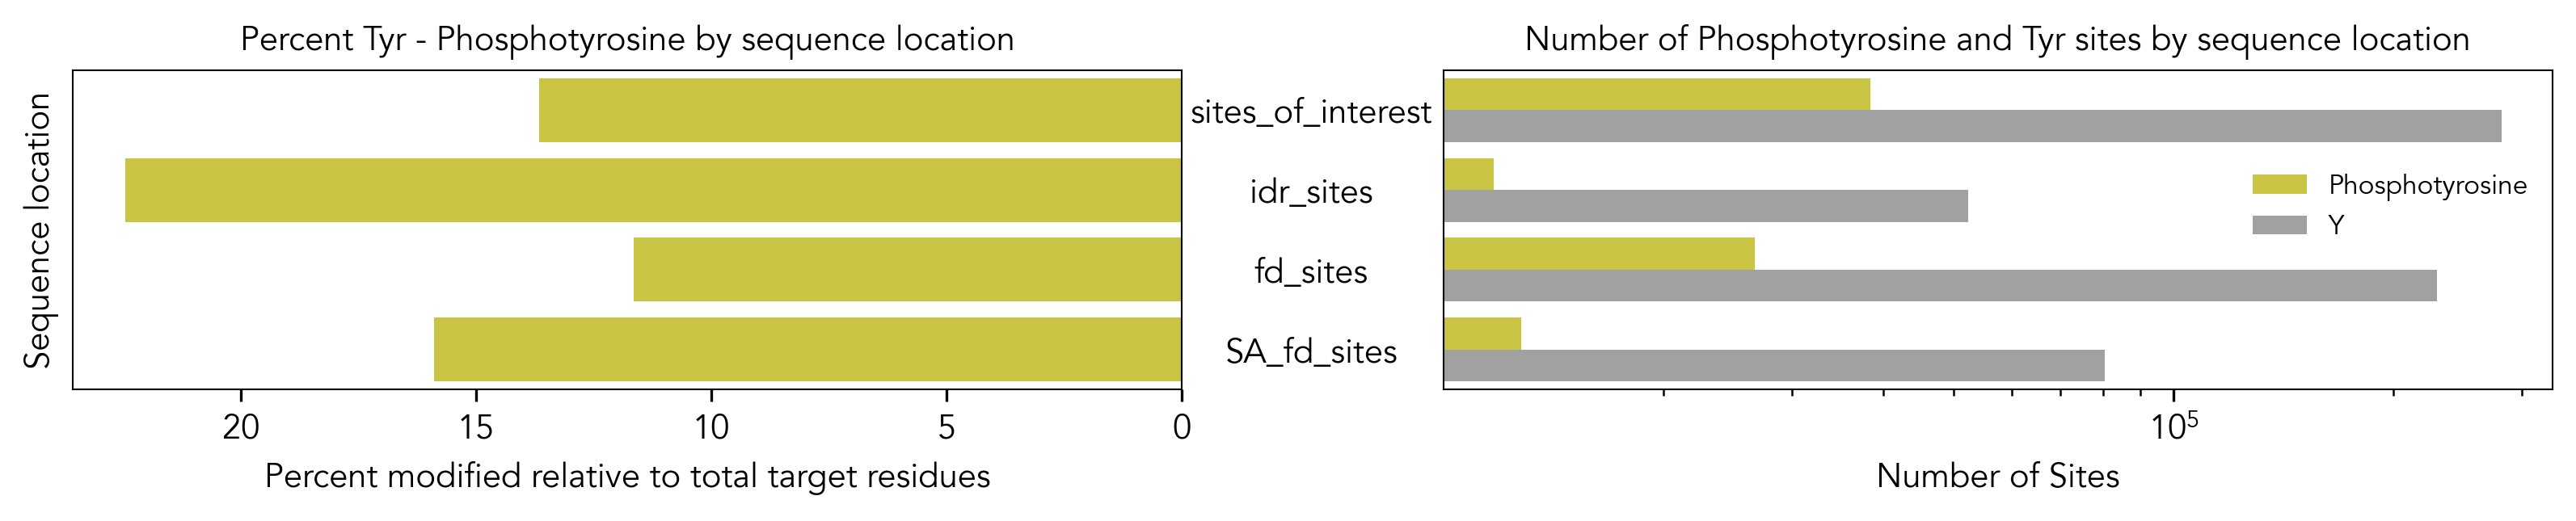

In [16]:
ptm = 'Phosphotyrosine'


residues = ", ".join([AA_letter_to_code[t] for t in PTM_target_dict[ptm]])
grouping = "_".join(PTM_target_dict[ptm])

filter_list = [ptm, grouping] # plot groups of targets

local_data = data_transformed[data_transformed.sites.isin(filter_list)]

f, ax = plt.subplots(ncols=2, figsize=(12, 3), dpi=150, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=.25)
f.tight_layout(pad=5)
# plot1
ax[0].invert_xaxis()
p1 = sns.barplot(y='variable',x='value', hue='sites' ,data=p_data_transformed[p_data_transformed['sites'] == ptm],
                 orient='h',ax=ax[0], palette=auto_ptm_palette)
ax[0].set_xlabel('Percent modified relative to total target residues')
ax[0].set_ylabel('Sequence location')
ax[0].set_yticks([])
ax[0].set_title("Percent %s - %s by sequence location" % (residues, ptm), fontsize=10)
#ax[0].set_xlim(25,0)
p1.legend_.remove()

# plot2
sns.barplot(y='variable',x='value', hue='sites',data=local_data, 
            orient='h', ax=ax[1], palette=auto_ptm_palette,log=True)
ax[1].set_xlabel('Number of Sites')
ax[1].tick_params(left=False)
ax[1].set_ylabel(None)
ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),ha='center', x=-.098, fontsize=10)
ax[1].set_title("Number of %s and %s sites by sequence location" % (ptm, residues), fontsize=10)
ax[1].legend(loc= 'center right',fontsize=8, bbox_to_anchor=(1,.57), frameon=False)

f.savefig('../FIGURES/Phosphotyrosine_Example.pdf')

## Plot all PTM data 
First plot comparing DIRs vs. solvent accessible sites

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_49255/3512275834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_data['value'] = local_data.apply(lambda x: x['value']*-1 if x['variable']=='SA_fd_sites' else x['value'], axis=1)
meta NOT subset; don't know how to subset; dropped


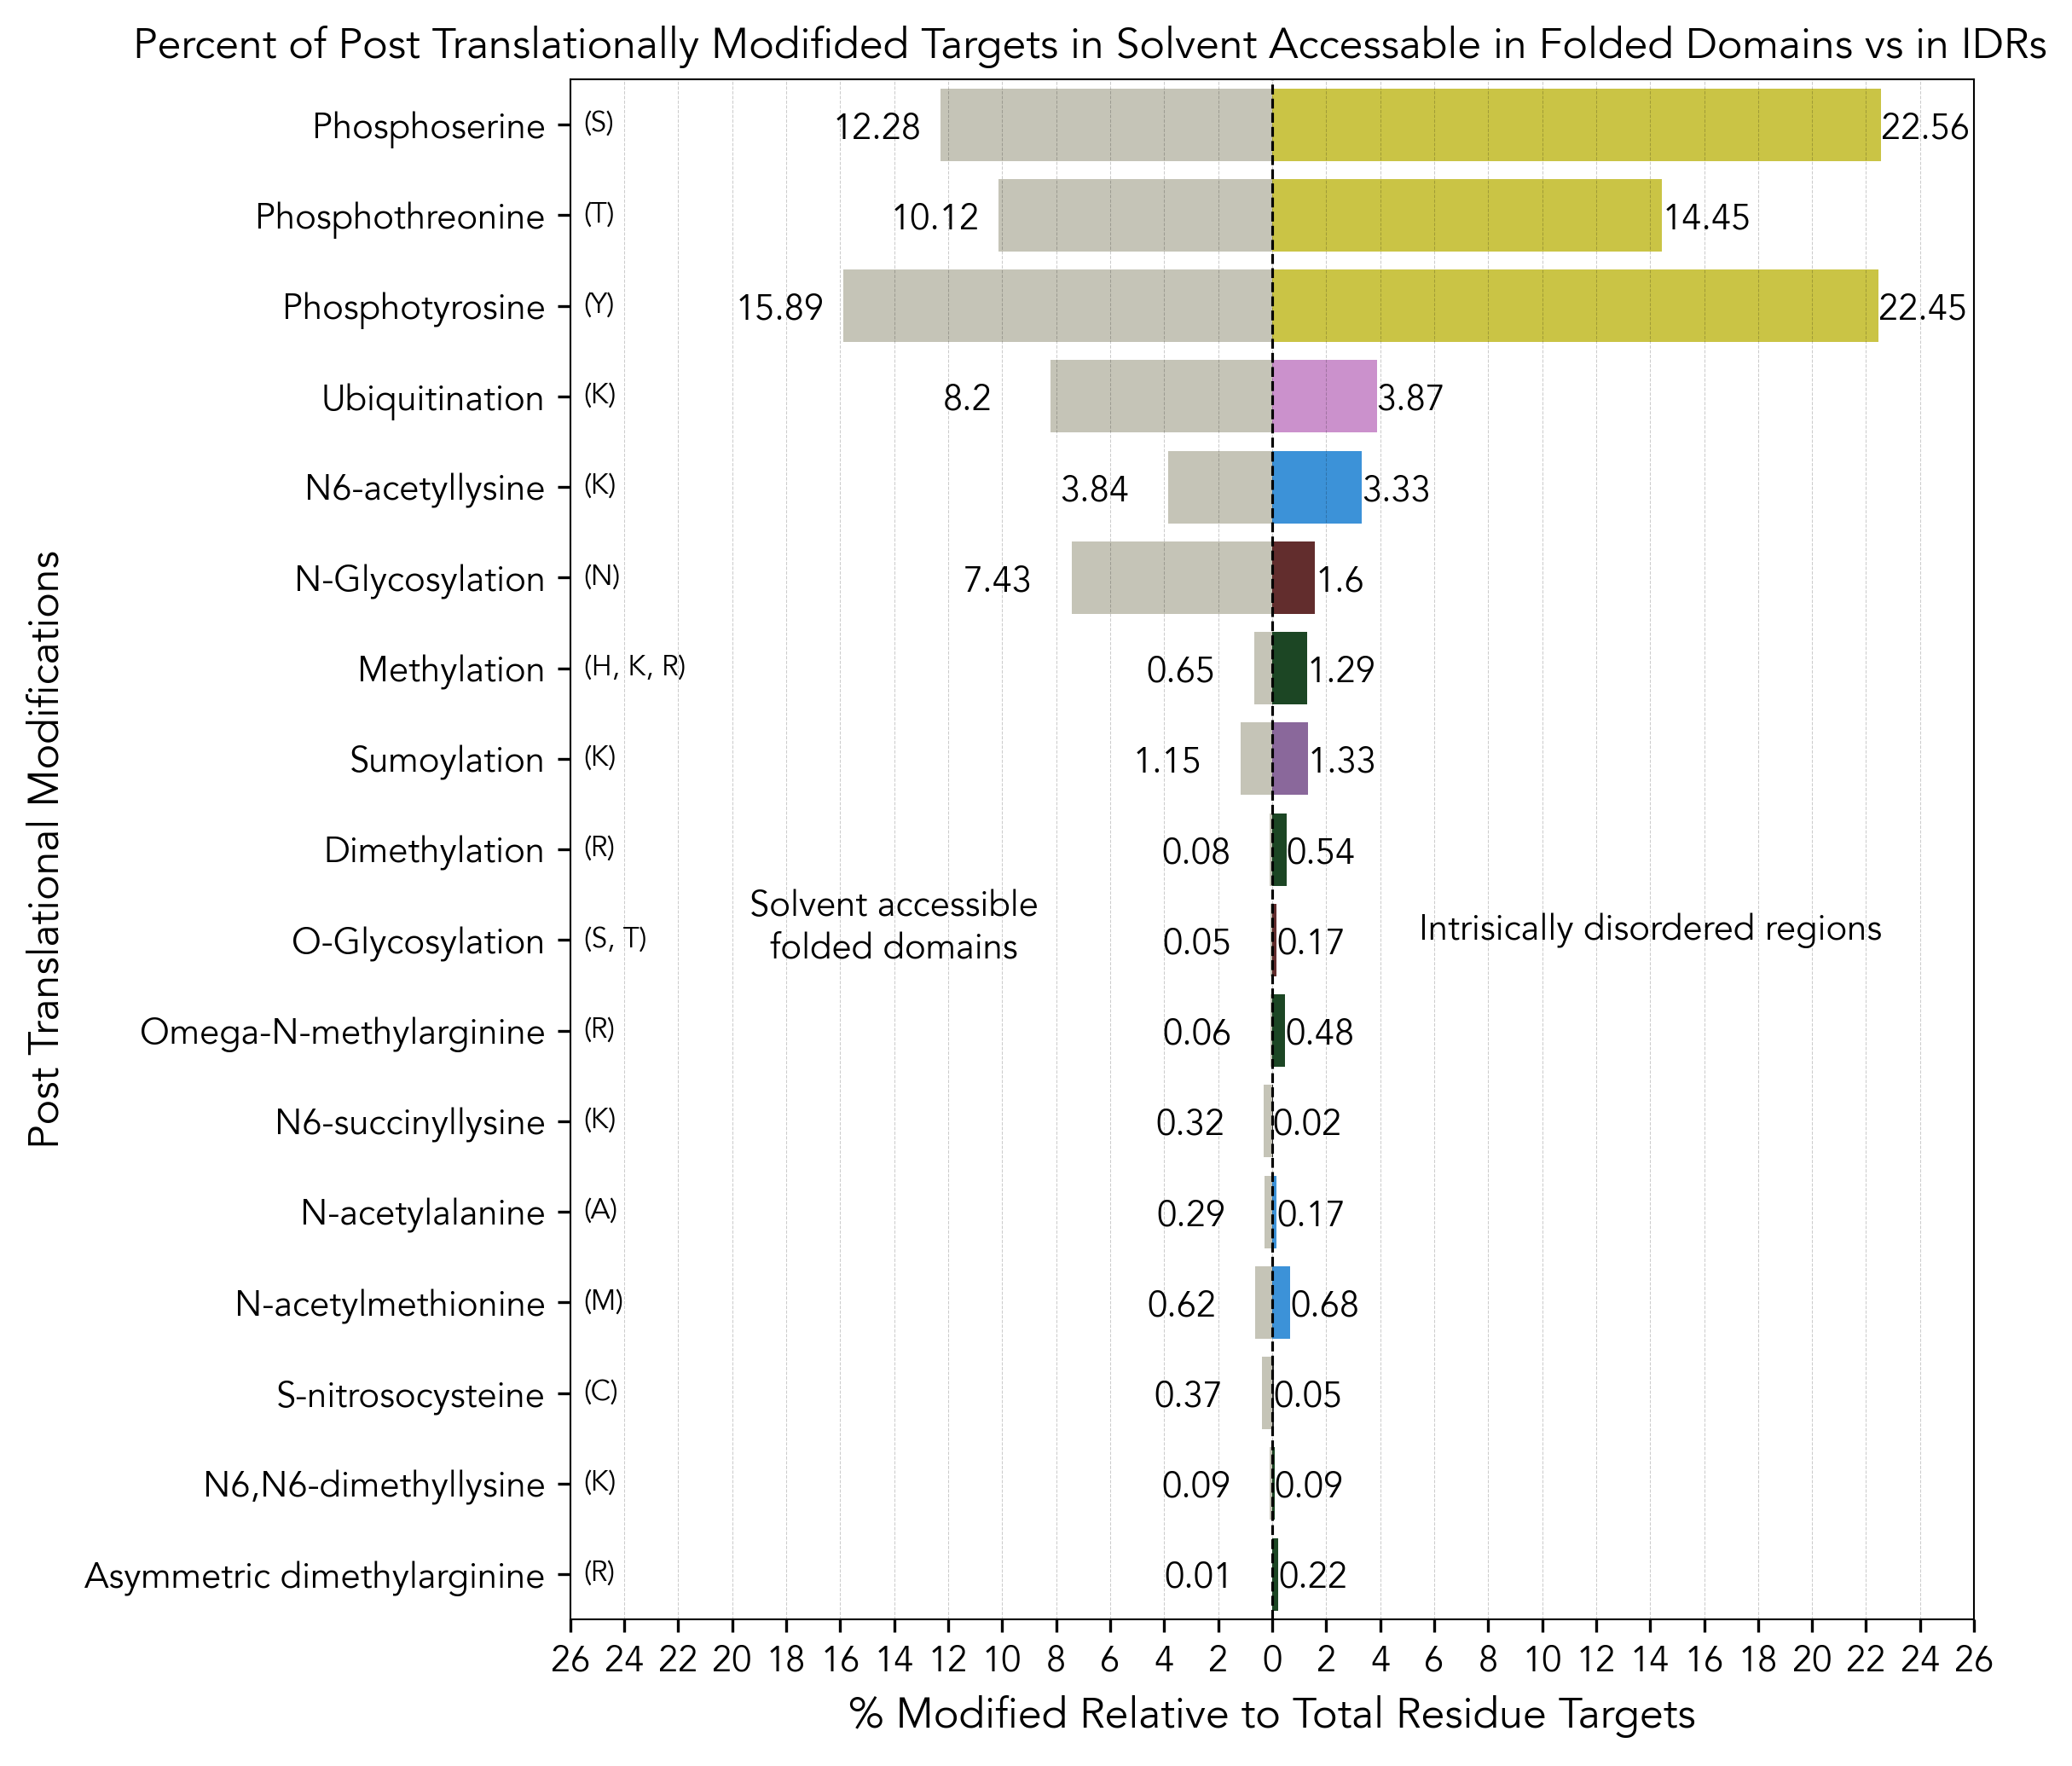

In [17]:
# make fd site value on left
local_data = p_data_transformed[p_data_transformed.variable.isin(['idr_sites','SA_fd_sites'])]
local_data['value'] = local_data.apply(lambda x: x['value']*-1 if x['variable']=='SA_fd_sites' else x['value'], axis=1)

# generate plots and plot data
f, ax = plt.subplots(1,1, figsize=(8, 7), dpi=150, facecolor='w', edgecolor='k')

ax.axvline(0,ls='--', c='k',lw=.75)

a1 = sns.barplot(y='sites',x='value', hue='sites',  orient='h' ,data=local_data[local_data['variable']=='idr_sites'],dodge=False,
            palette=auto_ptm_palette)

sns.barplot(y='sites',x='value', hue='variable',  orient='h' ,data=local_data[local_data['variable']=='SA_fd_sites'],
            palette=location_palette)

# set up x tick marks
plt.xlim([-26,26])
x_ticks = [i for i in range(-26,27,2)]
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.abs(x_ticks))

# set up y tick labels
target_labels = [", ".join([t for t in PTM_target_dict[l.get_text()]]) for l in ax.get_yticklabels()]
a1.legend_.remove()


# add some text
ax.text(-14,9.2,"Solvent accessible\nfolded domains", ha='center')
ax.text(14,9,"Intrisically disordered regions", ha='center')

for i, t in enumerate(target_labels):
    ax.text(-25.5,i,"(%s)" % t,fontsize=8,va='center')
    
    saval = list(local_data[local_data['variable']=='SA_fd_sites'].value)[i]
    idrval = list(local_data[local_data['variable']=='idr_sites'].value)[i]
    
    ax.text(saval-4,i+0.15 ,f"{np.round(-saval,2)}")
    ax.text(idrval,i+0.15 ,f"{np.round(idrval,2)}")
    
    
# set x, and y labels and title    
ax.set_xlabel('% Modified Relative to Total Residue Targets', fontsize=12)
ax.set_ylabel('Post Translational Modifications', fontsize=12)
ax.set_title('Percent of Post Translationally Modifided Targets in Solvent Accessable in Folded Domains vs in IDRs',x=.37, ha='center',fontsize=12)
ax.xaxis.grid(True, linestyle='--', color='k',alpha=.2, lw=.25)

plt.tight_layout()
f.savefig('../FIGURES/main_PTM_SA_FDvIDR.pdf')



/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_49255/902869442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_data['value'] = local_data.apply(lambda x: x['value']*-1 if x['variable']=='fd_sites' else x['value'], axis=1)
meta NOT subset; don't know how to subset; dropped


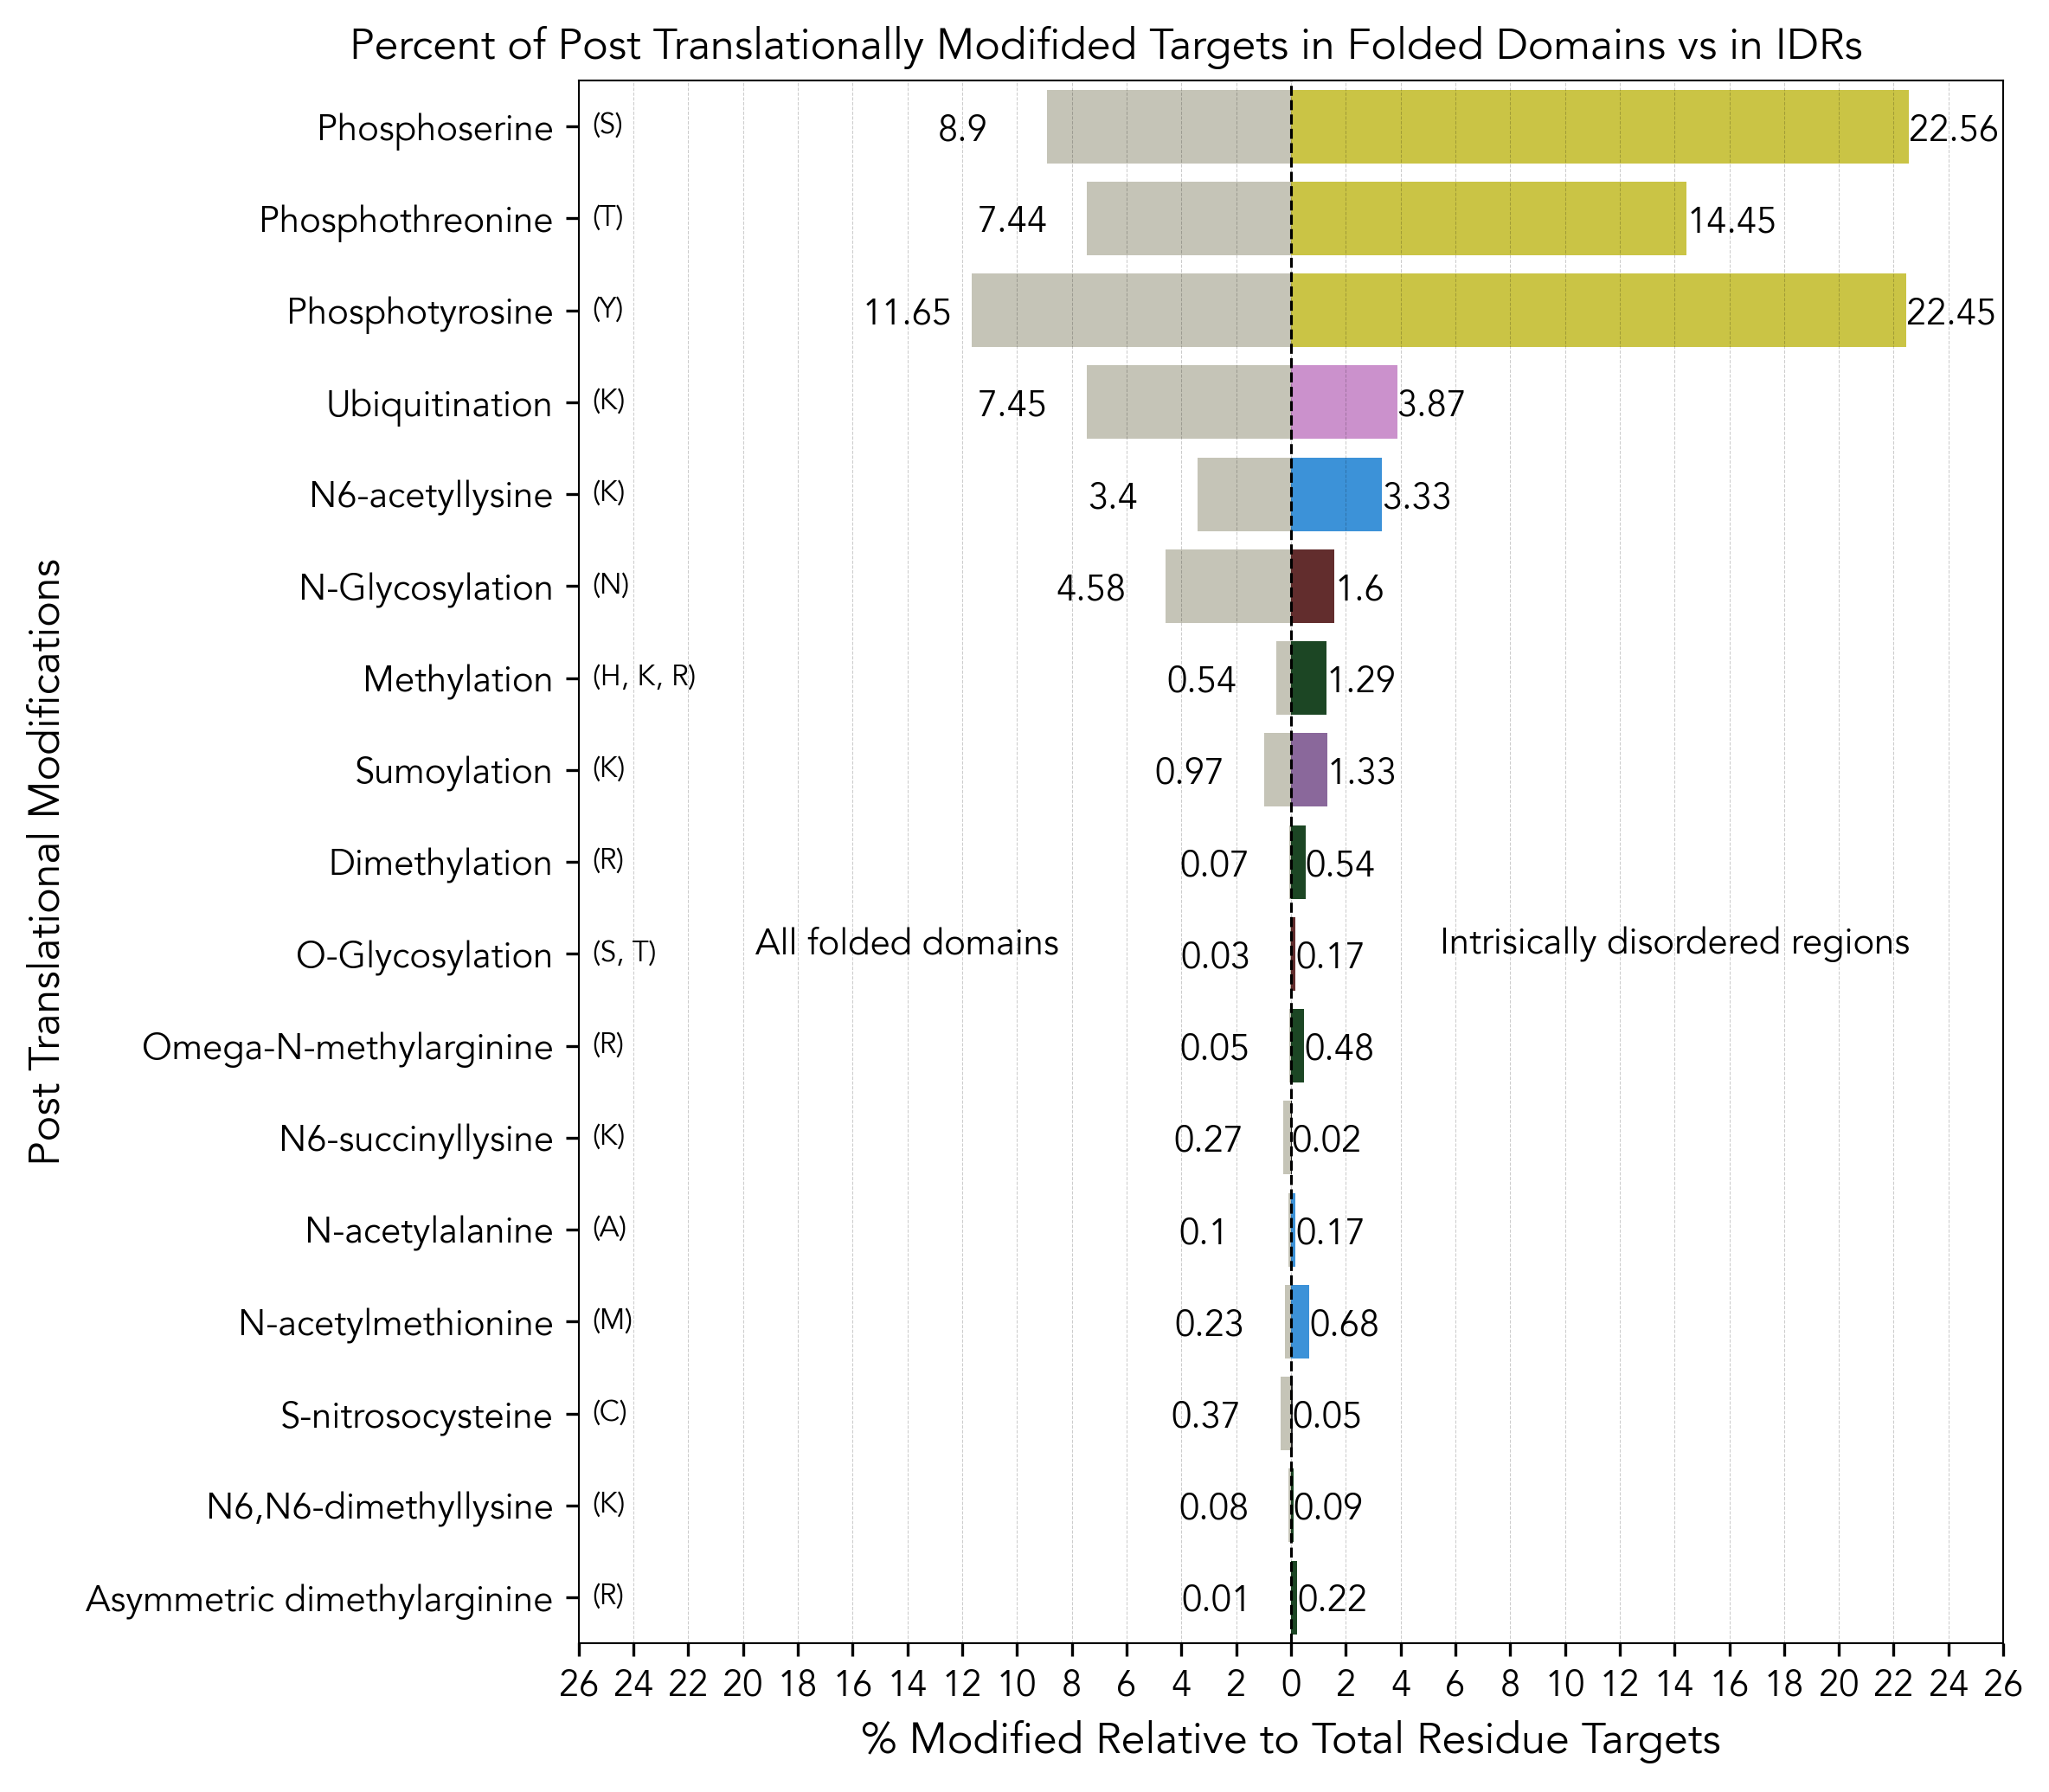

In [18]:
# make fd site value on left
local_data = p_data_transformed[p_data_transformed.variable.isin(['idr_sites','fd_sites'])]
local_data['value'] = local_data.apply(lambda x: x['value']*-1 if x['variable']=='fd_sites' else x['value'], axis=1)

f, ax = plt.subplots(1,1, figsize=(8, 7), dpi=150, facecolor='w', edgecolor='k')
ax.axvline(0,ls='--', c='k',lw=.75)
a1 = sns.barplot(y='sites',x='value', hue='sites',  orient='h' ,data=local_data[local_data['variable']=='idr_sites'],dodge=False,
            palette=auto_ptm_palette)
sns.barplot(y='sites',x='value', hue='variable',  orient='h' ,data=local_data[local_data['variable']=='fd_sites'],
            palette=location_palette)

plt.xlim([-26,26])
x_ticks = [i for i in range(-26,27,2)]

ax.set_xticks(x_ticks)
ax.set_xticklabels(np.abs(x_ticks))
target_labels = [", ".join([t for t in PTM_target_dict[l.get_text()]]) for l in ax.get_yticklabels()]
a1.legend_.remove()

ax.text(-14,9,"All folded domains", ha='center')
ax.text(14,9,"Intrisically disordered regions", ha='center')

for i, t in enumerate(target_labels):
    ax.text(-25.5,i,"(%s)" % t,fontsize=8,va='center')
    
    fdval = list(local_data[local_data['variable']=='fd_sites'].value)[i]
    idrval = list(local_data[local_data['variable']=='idr_sites'].value)[i]
    
    ax.text(fdval-4,i+0.15 ,f"{np.round(-fdval,2)}")
    ax.text(idrval,i+0.15 ,f"{np.round(idrval,2)}")
    
ax.set_xlabel('% Modified Relative to Total Residue Targets', fontsize=12)
ax.set_ylabel('Post Translational Modifications', fontsize=12)
ax.set_title('Percent of Post Translationally Modifided Targets in Folded Domains vs in IDRs',x=.37, ha='center',fontsize=12)
ax.xaxis.grid(True, linestyle='--', color='k',alpha=.2, lw=.25)

plt.tight_layout()
f.savefig('../FIGURES/main_PTM_all_FDvIDR.pdf')



# Saving data
To facilitate easy analysis of these annotations in the future, SHEPHARD makes it easy to save sites with the annotations we've generated here. This is achived in a single line, and the resulting file can be re-read back into a new session to annotate a new proteome but, importantly, can also just be opened in MS Excel or Numbers to see what's going on.

In [20]:
# all is needed is the proteome object and the destination!
si_sites.write_sites(af2_prot,'../generated_data/shprd_sites_ptms_with_idr_and_accessibility_attributes.tsv')


# Bonus analysis: Understanding inaccessible sites of PTMs
We wondered why so many proteins had 'inaccessible' sites that were modified. To explore this further, we extracted out all the modified sites that were annotated as being inaccessible, as well as the Protein objects from whence those sites came.

In [148]:
inaccesible_sites = []
proteins_with_inaccesible_sites = []

# for each protein
for protein in af2_prot:
    
    # for each site within that protein
    for site in protein.sites:
        
        # if the site has no attributes it's neither in an IDR nor annotated as being
        # solvent exposed
        if len(site.attributes) == 0:
            inaccesible_sites.append(site)
            proteins_with_inaccesible_sites.append(site.protein.unique_ID)

# finally we convert a list of IDs into a list of protein objects             
proteins_with_inaccesible_sites = [af2_prot.protein(i) for i in list(set(proteins_with_inaccesible_sites))]

In [149]:
uid_to_invalid_sites = {}
uid_to_valid_sites = {}

# this just formats the residues which are inaccessible vs. accessible into convenient strings which can be used
# with VMD and the AF2 structure to visualize where on the protein these sites fall
for p in proteins_with_inaccesible_sites:
    uid_to_invalid_sites[p.unique_ID] = " ".join([str(s.position) for s in p.sites if len(s.attributes) == 0])
    uid_to_valid_sites[p.unique_ID] = " ".join([str(s.position) for s in p.sites if len(s.attributes) > 0])
    
    
protein_count = len(uid_to_invalid_sites)
print(f'There are {protein_count} proteins with 1 or more "inaccessible" sites that get modified')

There are 12447 proteins with 1 or more "inaccessible" sites that get modified


### Case study on for PSMD2

We took a look at PSMD2 (TRAP2) (UID=Q13200) as an example of a protein with many inaccessible sites. Based on pLDDT scores and this proteins role in the broader structural context of the proteosome, we speculate these  seemingly inaccessible sites may be diagnostic of incorrect structural predictions for the 


In [150]:
# 
t='Q13200'
print('resid '+ uid_to_invalid_sites[t])
print('\n')
print('resid '+ uid_to_valid_sites[t])

resid 86 110 127 132 147 158 194 226 228 292 349 363 432 435 442 551 551 554 711 773


resid 1 8 16 24 27 29 31 39 41 46 50 66 79 88 90 91 94 105 107 119 134 137 141 168 178 186 189 286 343 350 350 357 361 397 434 436 439 441 499 508 712 754 858 860 902 906
